# What-If Tool Challenge Lab

In this notebook, you will use mortgage data from NY in 2017 to create two binary classifiers to determine if a mortgage applicant will be granted a loan.

You will train classifiers on two datasets. One will be trained on the complete dataset, and the other will be trained on a subset of the dataset, where 90% of the female applicants that were granted a loan were removed from the training data (so the dataset has 90% less females that were granted loans).

You will then compare and examine the two models using the What-If Tool.

In this notebook, you will be exepcted to:
* Understand how the data is processed 
* Write TensorFlow code to build and train two models
* Write code to deploy the the models to AI Platform
* Examine the models in the What-If Tool

In [1]:
%%bash

python3 -m pip install --no-cache-dir -qU pip wheel setuptools
python3 -m pip install --no-cache-dir -qU pandas numpy sklearn matplotlib
python3 -m pip install --no-cache-dir -qU witwidget tensorflow-gpu

# Download and import the data

Here, you'll import some modules and download some data from the Consumer Finance public [datasets](https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=ny&records=all-records&field_descriptions=labels).

In [1]:
import pandas as pd
import numpy as np
import collections
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [ ]:
!wget https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_ny_all-records_labels.zip
!unzip hmda_2017_ny_all-records_labels.zip

# Process the Data

In this section, you **don't need to write any code**. We suggest you read through the cells to understand how the dataset is processed.

Here, we start by importing the dataset into a Pandas dataframe. Then we process the data to exclude incomplete information and make a simple binary classification of loan approvals. We then create two datasets, one complete and one where 90% of female applicants are removed.

In [2]:
# Set column dtypes for Pandas
column_names = collections.OrderedDict({
    'as_of_year': np.int16,
    'agency_abbr': 'category',
    'loan_type': 'category',
    'property_type': 'category',
    'loan_purpose': 'category',
    'owner_occupancy': np.int8,
    'loan_amt_000s': np.float64,
    'preapproval': 'category',
    'county_code': np.float64,
    'applicant_income_00s': np.float64,
    'purchaser_type': 'category',
    'hoepa_status': 'category',
    'lien_status': 'category',
    'population': np.float64,
    'ffiec_median_fam_income': np.float64,
    'tract_to_msamd_income': np.float64,
    'num_of_owner_occupied_units': np.float64,
    'number_of_1_to_4_family_units': np.float64,
    'approved': np.int8, 
    'applicant_race_name_3': 'category',
    'applicant_race_name_4': 'category',
    'applicant_race_name_5': 'category',
    'co_applicant_race_name_3': 'category',
    'co_applicant_race_name_4': 'category',
    'co_applicant_race_name_5': 'category'
})

# Import the CSV into a dataframe
data = pd.read_csv('hmda_2017_ny_all-records_labels.csv', dtype=column_names)
data = shuffle(data, random_state=2)

## Extract columns and create dummy dataframes

We first specify which columns to keep then drop the columns that don't have `loan originated` or `loan denied`, to make this a simple binary classification.

We then create two dataframes `binary_df` and `bad_binary_df`. The first will include all the data, and the second will have 90% of female applicants removed, respectively. We then convert them into "dummy" dataframes to turn categorical string features into simple 0/1 features and normalize all the columns.

In [3]:
# Only use a subset of the columns for these models
text_columns_to_keep = [
    'agency_name',
    'loan_type_name',
    'property_type_name',
    'loan_purpose_name',
    'owner_occupancy_name',
    'applicant_ethnicity_name',
    'applicant_race_name_1',
    'applicant_sex_name',                      
]
numeric_columns_to_keep = [
    'loan_amount_000s',
    'applicant_income_000s',
    'population',
    'minority_population',
    'hud_median_family_income' 
]

columns_to_keep = text_columns_to_keep + numeric_columns_to_keep + ['action_taken_name']

# Drop columns with incomplete information and drop columns that don't have loan orignated or denied, to make this a simple binary classification
df = data[columns_to_keep].dropna()
binary_df = df[df.action_taken_name.isin(['Loan originated', 'Application denied by financial institution'])].copy()
binary_df.loc[:,'loan_granted'] = np.where(binary_df['action_taken_name'] == 'Loan originated', 1, 0)
binary_df = binary_df.drop(columns=['action_taken_name'])

# Drop 90% of loaned female applicants for a "bad training data" version
loaned_females = (binary_df['applicant_sex_name'] == 'Female') & (binary_df['loan_granted'] == 1)
bad_binary_df = binary_df.drop(binary_df[loaned_females].sample(frac=.9).index)

In [4]:
binary_df.head()

,agency_name,loan_type_name,property_type_name,loan_purpose_name,owner_occupancy_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,loan_granted
343075,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,Not Hispanic or Latino,White,Male,149,47.0,4108.0,15.820000,62500.0,1
259818,Consumer Financial Protection Bureau,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,Not Hispanic or Latino,White,Male,214,111.0,7470.0,14.230000,68200.0,1
431422,Department of Housing and Urban Development,VA-guaranteed,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,Not Hispanic or Latino,Black or African American,Male,163,86.0,3179.0,33.820000,73700.0,1
280518,Federal Deposit Insurance Corporation,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,Not Hispanic or Latino,White,Male,192,56.0,3527.0,3.370000,62500.0,1
107170,Consumer Financial Protection Bureau,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,Not Hispanic or Latino,White,Male,2000,358.0,5171.0,16.459999,73700.0,1


In [5]:
# Now lets' see the distribution of approved / denied classes (0: denied, 1: approved)
print(binary_df['loan_granted'].value_counts())

1    223026
0     63001
Name: loan_granted, dtype: int64


In [6]:
# Turn categorical string features into simple 0/1 features (like turning "sex" into "sex_male" and "sex_female")
dummies_df = pd.get_dummies(binary_df, columns=text_columns_to_keep)
dummies_df = dummies_df.sample(frac=1).reset_index(drop=True)

bad_dummies_df = pd.get_dummies(bad_binary_df, columns=text_columns_to_keep)
bad_dummies_df = bad_dummies_df.sample(frac=1).reset_index(drop=True)

In [7]:
# Normalize the numeric columns so that they all have the same scale to simplify modeling/training
def normalize():
    min_max_scaler = preprocessing.MinMaxScaler()
    column_names_to_normalize = ['loan_amount_000s', 'applicant_income_000s', 'minority_population', 'hud_median_family_income', 'population']
    x = dummies_df[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dummies_df.index)
    dummies_df[column_names_to_normalize] = df_temp

    x = bad_dummies_df[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    bad_df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = bad_dummies_df.index)
    bad_dummies_df[column_names_to_normalize] = bad_df_temp

normalize()

## Get the Train & Test Data

Now, let's get the train and test data for our models.

For the **first** model, you'll use `train_data` and `train_labels`.

For the **second** model, you'll use `limited_train_data` and `limited_train_labels`.

In [8]:
# Get the training data & labels
test_data_with_labels = dummies_df

train_data = dummies_df
train_labels = train_data['loan_granted']
train_data = train_data.drop(columns=['loan_granted'])

# Get the bad (limited) training data and labels
limited_train_data = bad_dummies_df
limited_train_labels = limited_train_data['loan_granted']
limited_train_data = bad_dummies_df.drop(columns=['loan_granted'])

# Split the data into train / test sets for Model 1
x, y = train_data,train_labels
train_data, test_data, train_labels, test_labels = train_test_split(x,y)

# Split the bad data into train / test sets for Model 2
lim_x,lim_y=limited_train_data,limited_train_labels
limited_train_data,limited_test_data,limited_train_labels,limited_test_labels = train_test_split(lim_x,lim_y)

# Create and train your TensorFlow models

In this section, you will write code to train two TensorFlow Keras models.

## Train your first model on the complete dataset.

* **Important**: your first model should be saved in the location `saved_complete_model/saved_model.pb`.
* The data will come from `train_data` and `train_labels`.

If you get stuck, you can view the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

In [9]:
# Plot the learning curves 
def plot_history(history):
    frame = pd.DataFrame(history.history)
    epochs = np.arange(len(frame))
    fig = plt.figure(figsize=(12, 4))
    # Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epochs, frame['loss'], label='Train')
    ax.plot(epochs, frame['val_loss'], label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss vs Epochs')
    ax.legend()
    # Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epochs, frame['accuracy'], label='Train')
    ax.plot(epochs, frame['val_accuracy'], label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs Epochs')
    ax.legend()
    plt.show()

In [16]:
# import TF modules
from tensorflow.keras import layers, initializers, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                624       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6704/6704 [=============================

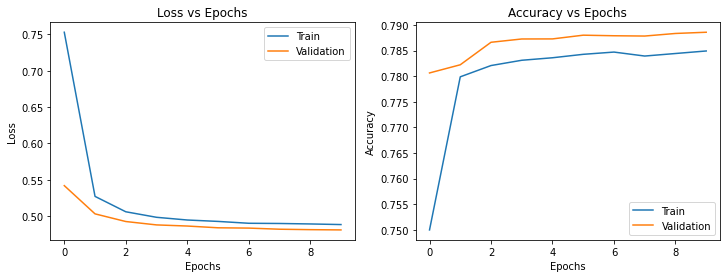

In [17]:
# This is the size of the array you'll be feeding into our model for each example
input_size = len(train_data.iloc[0])
kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=1.0)
kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-5)
bias_initializer = initializers.Ones()
bias_regularizer = regularizers.l2(l2=1e-5)
callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)]

# Train the first model on the complete dataset. Use `train_data` for your data and `train_labels` for you labels.

# ---- TODO ---------
# create the model = Sequential()
model = Sequential()
# model.add (your layers)
model.add(Dense(16, activation='relu',
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer,
    bias_initializer=bias_initializer,
    bias_regularizer=bias_regularizer,
    input_shape=(input_size,)))
model.add(layers.Dropout(0.3))
model.add(Dense(8, activation='relu',
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer,
    bias_initializer=bias_initializer,
    bias_regularizer=bias_regularizer))
model.add(layers.Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# model.compile
optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
# model.fit
history = model.fit(train_data, train_labels, batch_size=32, epochs=10, 
    validation_data=(test_data, test_labels), verbose=True,
    callbacks=callbacks)
plot_history(history)

In [ ]:
# Save your model
!mkdir -p saved_complete_model
model.save('saved_complete_model') 

In [18]:
# Get predictions on the test set and print the accuracy score (Model 1)
y_pred = model.predict(test_data)
acc = accuracy_score(test_labels, y_pred.round())
print("Model 1 Accuracy: %.2f%%" % (acc * 100.0))

Model 1 Accuracy: 78.86%


## Train your second model on the limited datset.

* **Important**: your second model should be saved in the location `saved_limited_model/saved_model.pb`.
* The data will come from `limited_train_data` and `limited_train_labels`.


If you get stuck, you can view the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                624       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5215/5215 [=============================

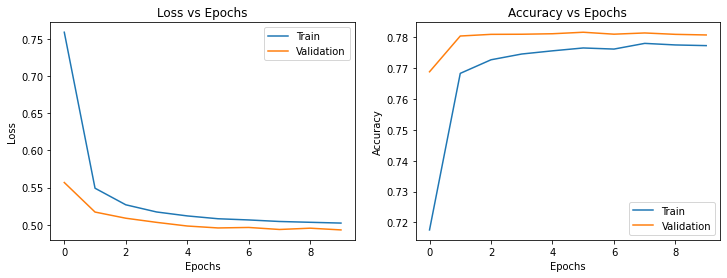

In [19]:
# Train your second model on the limited dataset. Use `limited_train_data` for your data and `limited_train_labels` for your labels.
# Use the same input_size for the limited_model

# ---- TODO ---------
# create the limited_model = Sequential()
limited_model = Sequential()
# limited_model.add (your layers)
limited_model.add(Dense(16, activation='relu',
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer,
    bias_initializer=bias_initializer,
    bias_regularizer=bias_regularizer,
    input_shape=(input_size,)))
limited_model.add(layers.Dropout(0.3))
limited_model.add(Dense(8, activation='relu',
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer,
    bias_initializer=bias_initializer,
    bias_regularizer=bias_regularizer))
limited_model.add(layers.Dropout(0.3))
limited_model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# limited_model.compile
optimizer = optimizers.Adam(learning_rate=1e-3)
limited_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
# limited_model.fit
limited_history = limited_model.fit(limited_train_data, limited_train_labels, 
    batch_size=32, epochs=10, verbose=True, callbacks=callbacks,
    validation_data=(limited_test_data, limited_test_labels))
plot_history(limited_history)

In [ ]:
# Save your model
!mkdir -p saved_limited_model
limited_model.save('saved_limited_model')

In [20]:
# Get predictions on the test set and print the accuracy score (Model 2)
limited_y_pred = limited_model.predict(limited_test_data)
acc = accuracy_score(limited_test_labels, limited_y_pred.round())
print("Model 2 Accuracy: %.2f%%" % (acc * 100.0))

Model 2 Accuracy: 78.08%


# Deploy your models to the AI Platform

In this section, you will first need to create a Cloud Storage bucket to store your models, then you will use gcloud commands to copy them over.

You will then create two AI Platform model resources and their associated versions.

In [ ]:
# ---- TODO ---------

# Fill out this information:

GCP_PROJECT = '#TODO'
MODEL_BUCKET = 'gs:// #TODO'
MODEL_NAME = 'saved_complete_model' #do not modify
LIM_MODEL_NAME = 'saved_limited_model' #do not modify
VERSION_NAME = 'v1'
REGION = 'us-central1'

In [ ]:
# Copy your model files to Cloud Storage (these file paths are your 'origin' for the AI Platform Model)
!gsutil cp -r ./saved_complete_model $MODEL_BUCKET
!gsutil cp -r ./saved_limited_model $MODEL_BUCKET

In [ ]:
# Configure gcloud to use your project
!gcloud config set project $GCP_PROJECT
!gcloud config set ai_platform/region global

## Create your first AI Platform model: *saved_complete_model*

Navigate back to the Google Cloud Console to complete this task. See the lab guide for details.

In [ ]:
!gcloud ai-platform models create $MODEL_NAME --regions $REGION

In [ ]:
!gcloud ai-platform versions create $VERSION_NAME \
--model=$MODEL_NAME \
--python-version=3.7 \
--framework='TensorFlow' \
--runtime-version=2.3 \
--origin=$MODEL_BUCKET/saved_complete_model \
--staging-bucket=$MODEL_BUCKET

## Create your second AI Platform model: *saved_limited_model*

Navigate back to the Google Cloud Console to complete this task. See the lab guide for details.

In [ ]:
!gcloud ai-platform models create $LIM_MODEL_NAME --regions $REGION

In [ ]:
!gcloud ai-platform versions create $VERSION_NAME \
--model=$LIM_MODEL_NAME \
--python-version=3.7 \
--framework='TensorFlow' \
--runtime-version=2.3 \
--origin=$MODEL_BUCKET/saved_limited_model \
--staging-bucket=$MODEL_BUCKET

# Using the What-if Tool to interpret your model
Once your models have deployed, you're now ready to connect them to the What-if Tool using the WitWidget. 

We've provided the Config Builder code and a couple of functions to get the class predictions from the models, which are necessary inputs for the WIT. If you've successfully deployed and saved your models, all you'll need to do is **add the WitConfigBuilder code in this cell**.

In [ ]:
#@title Show model results in WIT
num_datapoints = 1000  #@param {type: "number"}

# Column indices to strip out from data from WIT before passing it to the model.
columns_not_for_model_input = [
    test_data_with_labels.columns.get_loc('loan_granted'),
]

# Return model predictions.
def custom_predict(examples_to_infer):
    # Delete columns not used by model
    model_inputs = np.delete(
      np.array(examples_to_infer), columns_not_for_model_input, axis=1).tolist()
    # Get the class predictions from the model.
    preds = model.predict(model_inputs)
    preds = [[1 - pred[0], pred[0]] for pred in preds]
    return preds
  
# Return 'limited' model predictions.
def bad_custom_predict(examples_to_infer):
    # Delete columns not used by model
    model_inputs = np.delete(
      np.array(examples_to_infer), columns_not_for_model_input, axis=1).tolist()
    # Get the class predictions from the model.
    preds = limited_model.predict(model_inputs)
    preds = [[1 - pred[0], pred[0]] for pred in preds]
    return preds

examples_for_wit = test_data_with_labels.values.tolist()
column_names = test_data_with_labels.columns.tolist()

# ---- TODO ------ 

## Add WitConfigBuilder code here
config_builder = (WitConfigBuilder(
    examples_for_wit[:num_datapoints], feature_names=column_names)
    .set_custom_predict_fn(bad_custom_predict)
    .set_target_feature('loan_granted')
    .set_label_vocab(['denied', 'accepted'])
    .set_compare_custom_predict_fn(custom_predict)
    .set_model_name('limited')
    .set_compare_model_name('complete'))
WitWidget(config_builder, height=800)